In [1]:
import os
import sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import minimize
    
def valid_invalid(normalized_speckles,wave,err,err_hpf):
    valid = []
    invalid = []
    for j in range(len(wave)):
        std = np.nanstd(normalized_speckles[j,:])
        boolean1 = (std - 1 < 1e-12)
        boolean2 = np.logical_not(np.isnan(err[j]))
        boolean3 = np.logical_not(np.isnan(err_hpf[j]))
        if boolean1 and boolean2 and boolean3:
            valid.append(j)
        else:
            invalid.append(j)  
    return valid, invalid

def calc_corr(normalized_speckles,wave):
    correlations = []
    stds = []
    Nsamps = []
    for idelt in range(len(wave)):
        if idelt == 0:
            left_speckles = normalized_speckles[:]
            right_speckles = normalized_speckles[:]
        else: 
            left_speckles = normalized_speckles[:-idelt]
            right_speckles = normalized_speckles[idelt:]
        mean_correlation = np.nanmean(left_speckles*right_speckles)
        std_correlation = np.nanstd(left_speckles*right_speckles)
        Nsamples = left_speckles.shape[0]*left_speckles.shape[1]
        correlations.append(mean_correlation)
        stds.append(std_correlation)
        Nsamps.append(Nsamples)
    return correlations, stds, Nsamps

def define_gaussian_model_fn(params):
    a0, s0, a1, s1 = params
    def f(x):
        return a0*np.exp(-x**2/(2*s0**2)) + a1*np.exp(-x**2/(2*s1**2))
    return f

def chi2(params):
    f = define_gaussian_model_fn(params)
    model = f(delta_pixels)
    chi2 = np.nansum((correlations-model)**2/mean_error**2)
    return chi2

def djiM(wave):
    dji_Matrix = np.ones((len(wave),len(wave)))*np.nan
    for i in valid:
        for j in valid:
            dji = j-i 
            dji_Matrix[i,j] = dji
    return dji_Matrix

In [2]:

data_dir = "/home/jruffio/code/jwst_scripts/HD_19467_B/data/"
RDI_1dspectrum_speckles_filename = os.path.join(data_dir,"HD19467b_RDI_1dspectrum_speckles_Flambda_modified.fits")
RDI_1dspectrum_spectra_filename = os.path.join(data_dir,"HD19467b_RDI_1dspectrum_Flambda_modified.fits")
covariance_filename = os.path.join(data_dir,"HD19467b_covariance.fits")

In [3]:
#load data
with fits.open(RDI_1dspectrum_speckles_filename) as hdulist:
    wave = hdulist[0].data
    spec = hdulist[1].data
    smooth = hdulist[2].data
with fits.open(RDI_1dspectrum_spectra_filename) as hdulist:
    err = hdulist[2].data
    err_hpf = hdulist[3].data
wave1shape = (spec.shape[0],1)
speckles = spec - smooth.reshape(wave1shape)

#normalize speckles by standard deviation over spatial positions
std_wave = np.nanstd(speckles,axis=1)
std_wave2d = std_wave.reshape(wave1shape)
normalized_speckles = speckles/std_wave2d

#calculate valid pixel indices
valid, invalid = valid_invalid(normalized_speckles,wave,err,err_hpf)

#calculation correlation function
correlations, stds, Nsamps = calc_corr(normalized_speckles,wave)
correlations = np.array(correlations)
mean_error = np.array(stds)/np.sqrt(np.array(Nsamps))

# calculate optimal double gaussian model
delta_pixels = np.arange(len(correlations))
xopt = minimize(chi2,[1,100, .1, 1000])
fopt = define_gaussian_model_fn(xopt['x'])
correlation_model = fopt(delta_pixels)

#subtract uncorrelated error component and normalize
component = np.zeros(len(correlations))
component[0:2] = correlations[0:2] - correlations[2]
component_n = component/component[0]
correlation_model_n = correlation_model/correlation_model[0]

#create interpolation function for correlated and uncorrelated error models
delta_pixels = np.arange(len(correlations))
interp_corr = lambda x: np.interp(x,delta_pixels,correlation_model_n)
interp_comp = lambda x: np.interp(x,delta_pixels,component_n)

#apply interpolated error model to grid of delta pixels
dji = djiM(wave)
ms = interp_corr(abs(dji))
mc = interp_comp(abs(dji))

#outer products of error vectors
err_outer = err.reshape(wave1shape)*err.reshape(wave1shape).T
err_hpf_outer = err_hpf.reshape(wave1shape)*err_hpf.reshape(wave1shape).T

#compute total covariance from linear combination of error models and remove invalid pixels
Covariance_Matrix = ms*err_outer + mc*err_hpf_outer
valid_Covariance_Matrix = Covariance_Matrix[valid,:][:,valid]

#create samples and invert covariance
random_sample = np.random.multivariate_normal(np.zeros(len(valid)),valid_Covariance_Matrix,size=10)
cov_inv = np.linalg.inv(valid_Covariance_Matrix)

#save covariance, inverse, and valid pixel indices
card0 = ('NAME','Covariance Matrix','')
h0 = fits.Header(cards=[card0])
card1 = ('NAME','Valid Pixels','3417 valid pixels out of 3635 total pixels')
card2 = ('USE','Slicing example:','Covariance_Matrix[valid,:][:,valid]')
h1 = fits.Header(cards=[card1,card2])
card3 = ('NAME','Inverse Covariance Matrix','')
h2 = fits.Header(cards=[card3])
hdu0 = fits.PrimaryHDU(Covariance_Matrix,header=h0)
hdu1 = fits.ImageHDU(valid,header=h1)
hdu2 = fits.ImageHDU(cov_inv,header=h2)
hdulist = fits.HDUList([hdu0,hdu1,hdu2])
hdulist.writeto(covariance_filename)

/home/jruffio/anaconda3/envs/20231220_breads_jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_495341/797439530.py:33: RuntimeWarning: Mean of empty slice
  mean_correlation = np.nanmean(left_speckles*right_speckles)


In [4]:
#paper figures
color_list = ["#FF9900","#006699", "#6600FF"]

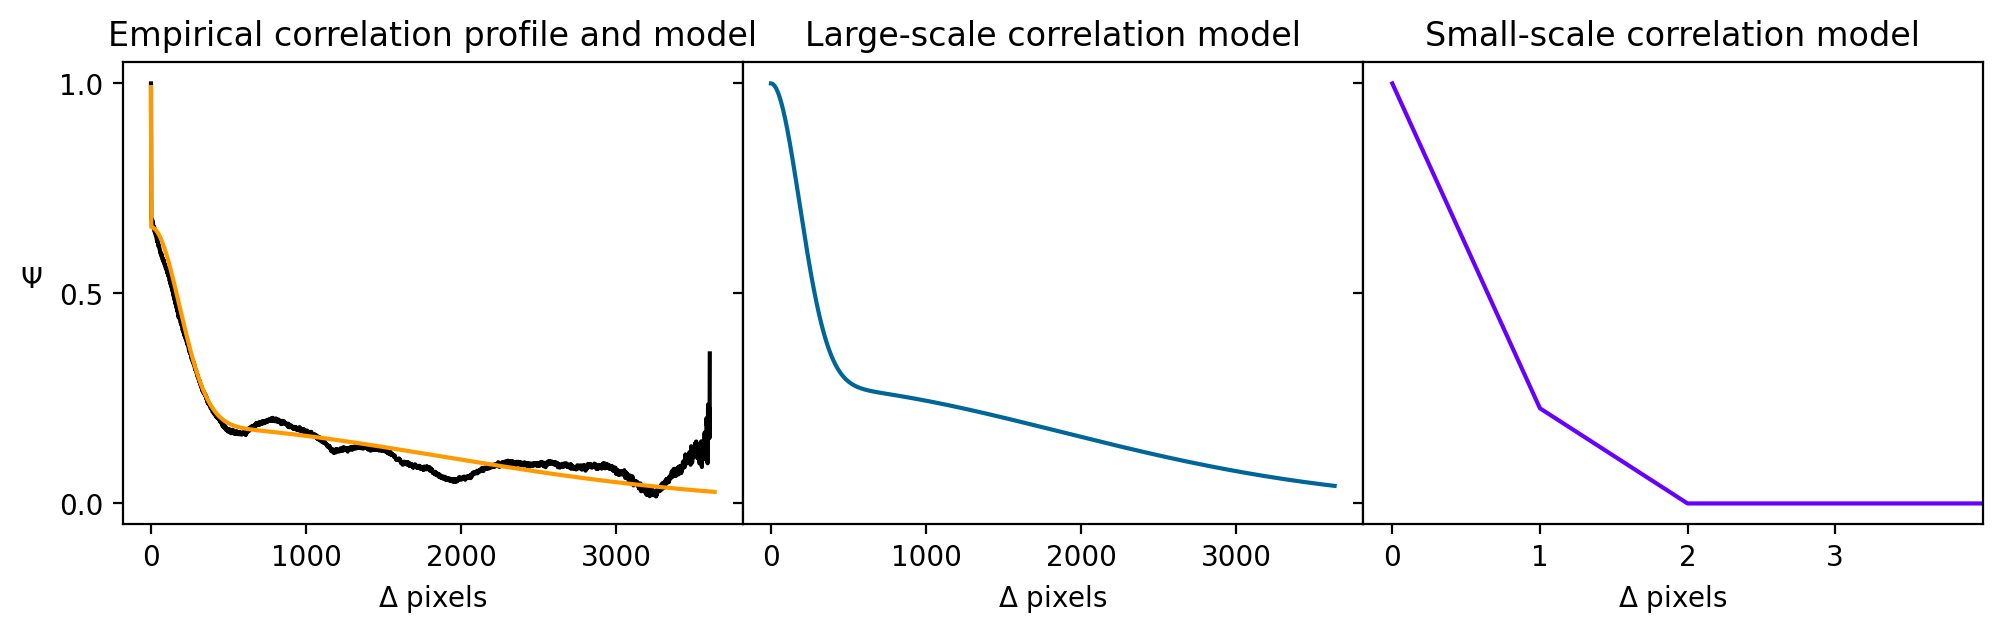

In [5]:
fig,ax = plt.subplots(1,3,figsize=(12,3),dpi=200,sharey=True)
ax[0].plot(delta_pixels,correlations/correlations[0],'k-')
ax[0].plot(delta_pixels,component+correlation_model,color_list[0])

ax[1].plot(delta_pixels,correlation_model_n,color_list[1])
ax[2].plot(delta_pixels,component_n,color_list[2])

ax[0].set_yticks([0,0.5,1])
ax[0].set_xlabel(r'$\Delta$ pixels')
ax[1].set_xlabel(r'$\Delta$ pixels')
ax[2].set_xlabel(r'$\Delta$ pixels')
ax[0].set_ylabel(r'$\Psi$',rotation=0,labelpad=10)
ax[2].set_xlim([-.2,4])
ax[2].set_xticks(np.arange(4))

ax[0].set_title('Empirical correlation profile and model')
ax[1].set_title('Large-scale correlation model')
ax[2].set_title('Small-scale correlation model')

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

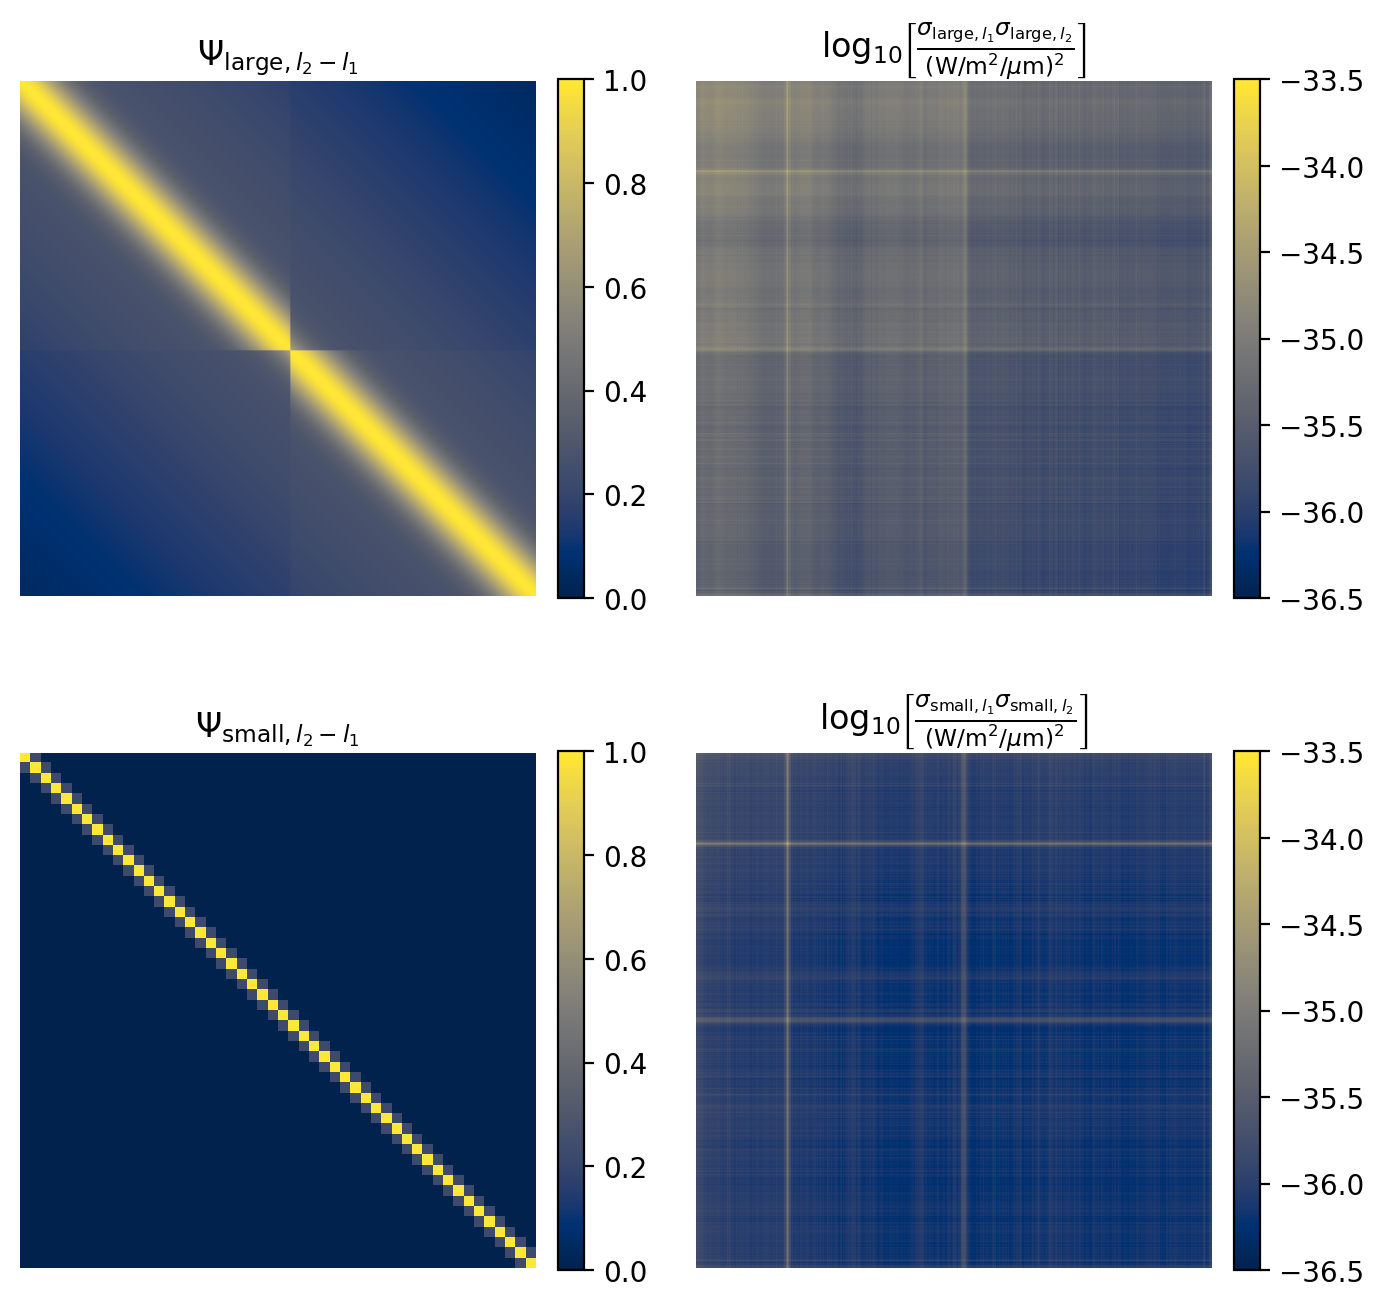

In [6]:
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=200)

im00 = ax[0,0].imshow(ms[valid,:][:,valid],vmin=0,vmax=1,cmap='cividis')
im10 = ax[1,0].imshow(mc[20:70,20:70],vmin=0,vmax=1,cmap='cividis')
im01 = ax[0,1].imshow(np.log10(err_outer[valid,:][:,valid]),cmap='cividis',vmin=-36.5,vmax=-33.5)
im11 = ax[1,1].imshow(np.log10(err_hpf_outer[valid,:][:,valid]),cmap='cividis',vmin=-36.5,vmax=-33.5)

fig.colorbar(im00,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(im10,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(im01,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(im11,ax=ax[1,1],fraction=0.046, pad=0.04)

ax[0,0].set_title(r'$\Psi_{\mathrm{large},l_2-l_1}$')
ax[1,0].set_title(r'$\Psi_{\mathrm{small},l_2-l_1}$')
ax[0,1].set_title(r'log$_{10} \left[\frac{\sigma_{\mathrm{large},l_1}\sigma_{\mathrm{large},l_2}}{(\mathrm{W}/\mathrm{m}^2/\mu \mathrm{m})^2}\right]$')
ax[1,1].set_title(r'log$_{10} \left[\frac{\sigma_{\mathrm{small},l_1}\sigma_{\mathrm{small},l_2}}{(\mathrm{W}/\mathrm{m}^2/\mu \mathrm{m})^2}\right]$')

ax[0,0].axis('off')
ax[1,0].axis('off')
ax[0,1].axis('off')
ax[1,1].axis('off')

plt.show()

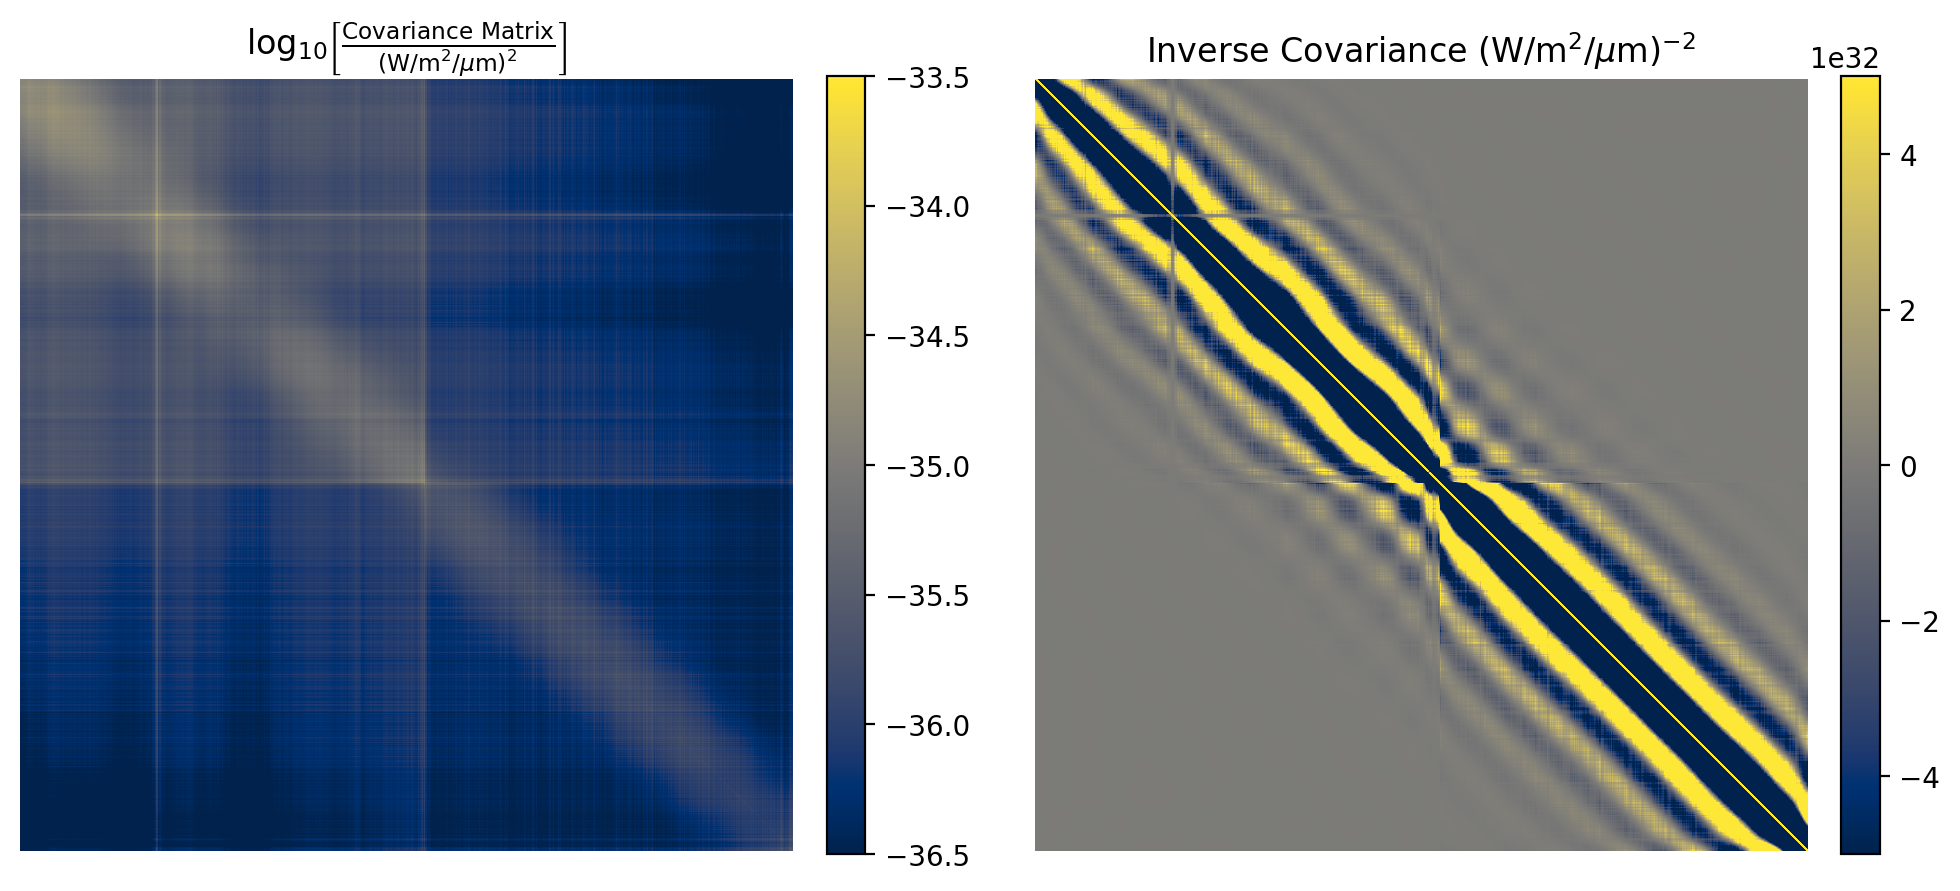

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,8),dpi=200)

im0 = ax[0].imshow(np.log10(valid_Covariance_Matrix),cmap='cividis',vmin=-36.5,vmax=-33.5)
im1 = ax[1].imshow(cov_inv,vmin=-5e32,vmax=5e32,cmap='cividis')

fig.colorbar(im0,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(im1,ax=ax[1],fraction=0.046, pad=0.04)

ax[0].set_title(r'log$_{10} \left[\frac{\mathrm{Covariance\ Matrix}}{(\mathrm{W}/\mathrm{m}^2/\mu \mathrm{m})^2}\right]$')
ax[1].set_title(r'Inverse Covariance $(\mathrm{W}/\mathrm{m}^2/\mu \mathrm{m})^{-2}$')

ax[0].axis('off')
ax[1].axis('off')
plt.show()

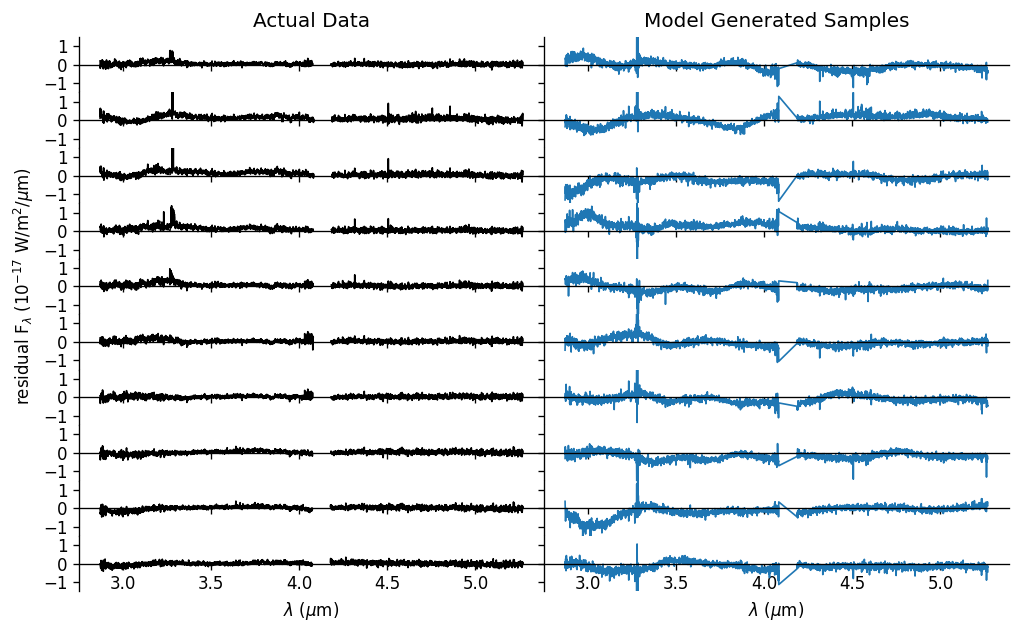

In [8]:
fig,ax = plt.subplots(10,2,figsize=(10,6),dpi=120,sharex=True,sharey=True)

for i in range(0,10):
    ax[i,0].plot(wave,speckles[:,i]*1e17,'k-',linewidth=1)
    ax[i,1].plot(wave[valid],random_sample.T[:,i]*1e17,linewidth=1)

for a in ax.ravel():
    a.spines['right'].set_color('none')
    a.spines['bottom'].set_position('zero')
    a.spines['top'].set_color('none')

ax[9,0].set_xlabel(r'$\lambda$ ($\mu$m)')
ax[9,1].set_xlabel(r'$\lambda$ ($\mu$m)')

ax[4,0].set_ylabel(r'residual F$_\lambda$ (10$^{-17}$ W/m$^2$/$\mu$m)',rotation=90)

ax[0,0].set_title('Actual Data')
ax[0,1].set_title('Model Generated Samples')

plt.ylim([-1.5,1.5])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()